In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [8]:
# ============================================================================
# PART 1: DATA LOADING AND INITIAL EXPLORATION
# ============================================================================
print("="*80)
print("BANK PERSONAL LOAN APPROVAL - LOGISTIC REGRESSION ANALYSIS")
print("="*80)

# Load data
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv")
print(f"\n1. Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")

# Initial data exploration
print("\n2. Dataset Overview:")
print(df.head())
print("\n3. Data Types:")
print(df.dtypes)
print("\n4. Dataset Information:")
print(df.info())


BANK PERSONAL LOAN APPROVAL - LOGISTIC REGRESSION ANALYSIS

1. Dataset loaded successfully: 5000 rows, 14 columns

2. Dataset Overview:
   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0            

In [10]:
# ============================================================================
# PART 2: DATA QUALITY ASSESSMENT
# ============================================================================
print("\n" + "="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Check for missing values
print("\n5. Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n6. Duplicate Rows: {duplicates}")

# Statistical summary
print("\n7. Statistical Summary:")
print(df.describe())

# Check for outliers using IQR method
print("\n8. Outlier Detection (using IQR method):")
numeric_cols = df.select_dtypes(include=[np.number]).columns
outlier_summary = {}
for col in numeric_cols:
    if col != 'ID':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col].count()
        outlier_summary[col] = outliers
        if outliers > 0:
            print(f"   {col}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")



DATA QUALITY ASSESSMENT

5. Missing Values:
No missing values found

6. Duplicate Rows: 0

7. Statistical Summary:
                ID          Age   Experience       Income      ZIP Code  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean   2500.500000    45.338400    20.104600    73.774200  93152.503000   
std    1443.520003    11.463166    11.467954    46.033729   2121.852197   
min       1.000000    23.000000    -3.000000     8.000000   9307.000000   
25%    1250.750000    35.000000    10.000000    39.000000  91911.000000   
50%    2500.500000    45.000000    20.000000    64.000000  93437.000000   
75%    3750.250000    55.000000    30.000000    98.000000  94608.000000   
max    5000.000000    67.000000    43.000000   224.000000  96651.000000   

            Family        CCAvg    Education     Mortgage  Personal Loan  \
count  5000.000000  5000.000000  5000.000000  5000.000000    5000.000000   
mean      2.396400     1.937938     1.881000    56.49880

In [12]:
# ============================================================================
# PART 3: DATA CLEANING
# ============================================================================
print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

# Create a copy for cleaning
df_clean = df.copy()

# Drop ID column (not useful for modeling)
df_clean.drop('ID', axis=1, inplace=True)
print("\n9. Removed 'ID' column (not relevant for analysis)")

# Check for negative values in columns that shouldn't have them
print("\n10. Checking for invalid values:")
negative_income = (df_clean['Income'] < 0).sum()
negative_exp = (df_clean['Experience'] < 0).sum()
print(f"   Negative Income values: {negative_income}")
print(f"   Negative Experience values: {negative_exp}")

# Handle negative experience values (data quality issue)
if negative_exp > 0:
    df_clean['Experience'] = df_clean['Experience'].abs()
    print(f"   → Converted {negative_exp} negative Experience values to absolute values")

# Check for logical inconsistencies
print("\n11. Checking logical consistency:")
age_exp_issue = (df_clean['Age'] < df_clean['Experience']).sum()
print(f"   Cases where Experience > Age: {age_exp_issue}")

if age_exp_issue > 0:
    # Cap experience at age - 18 (assuming minimum working age)
    df_clean['Experience'] = df_clean.apply(
        lambda row: min(row['Experience'], row['Age'] - 18) if row['Age'] > 18 else 0, 
        axis=1
    )
    print(f"   → Adjusted Experience values to be consistent with Age")

# Remove duplicates if any
if duplicates > 0:
    df_clean.drop_duplicates(inplace=True)
    print(f"\n12. Removed {duplicates} duplicate rows")

print(f"\n13. Clean dataset shape: {df_clean.shape}")


DATA CLEANING

9. Removed 'ID' column (not relevant for analysis)

10. Checking for invalid values:
   Negative Income values: 0
   Negative Experience values: 52
   → Converted 52 negative Experience values to absolute values

11. Checking logical consistency:
   Cases where Experience > Age: 0

13. Clean dataset shape: (5000, 13)



EXPLORATORY DATA ANALYSIS

14. Target Variable Distribution:
Personal Loan
0    4520
1     480
Name: count, dtype: int64

Class Balance: 9.60% accepted loan


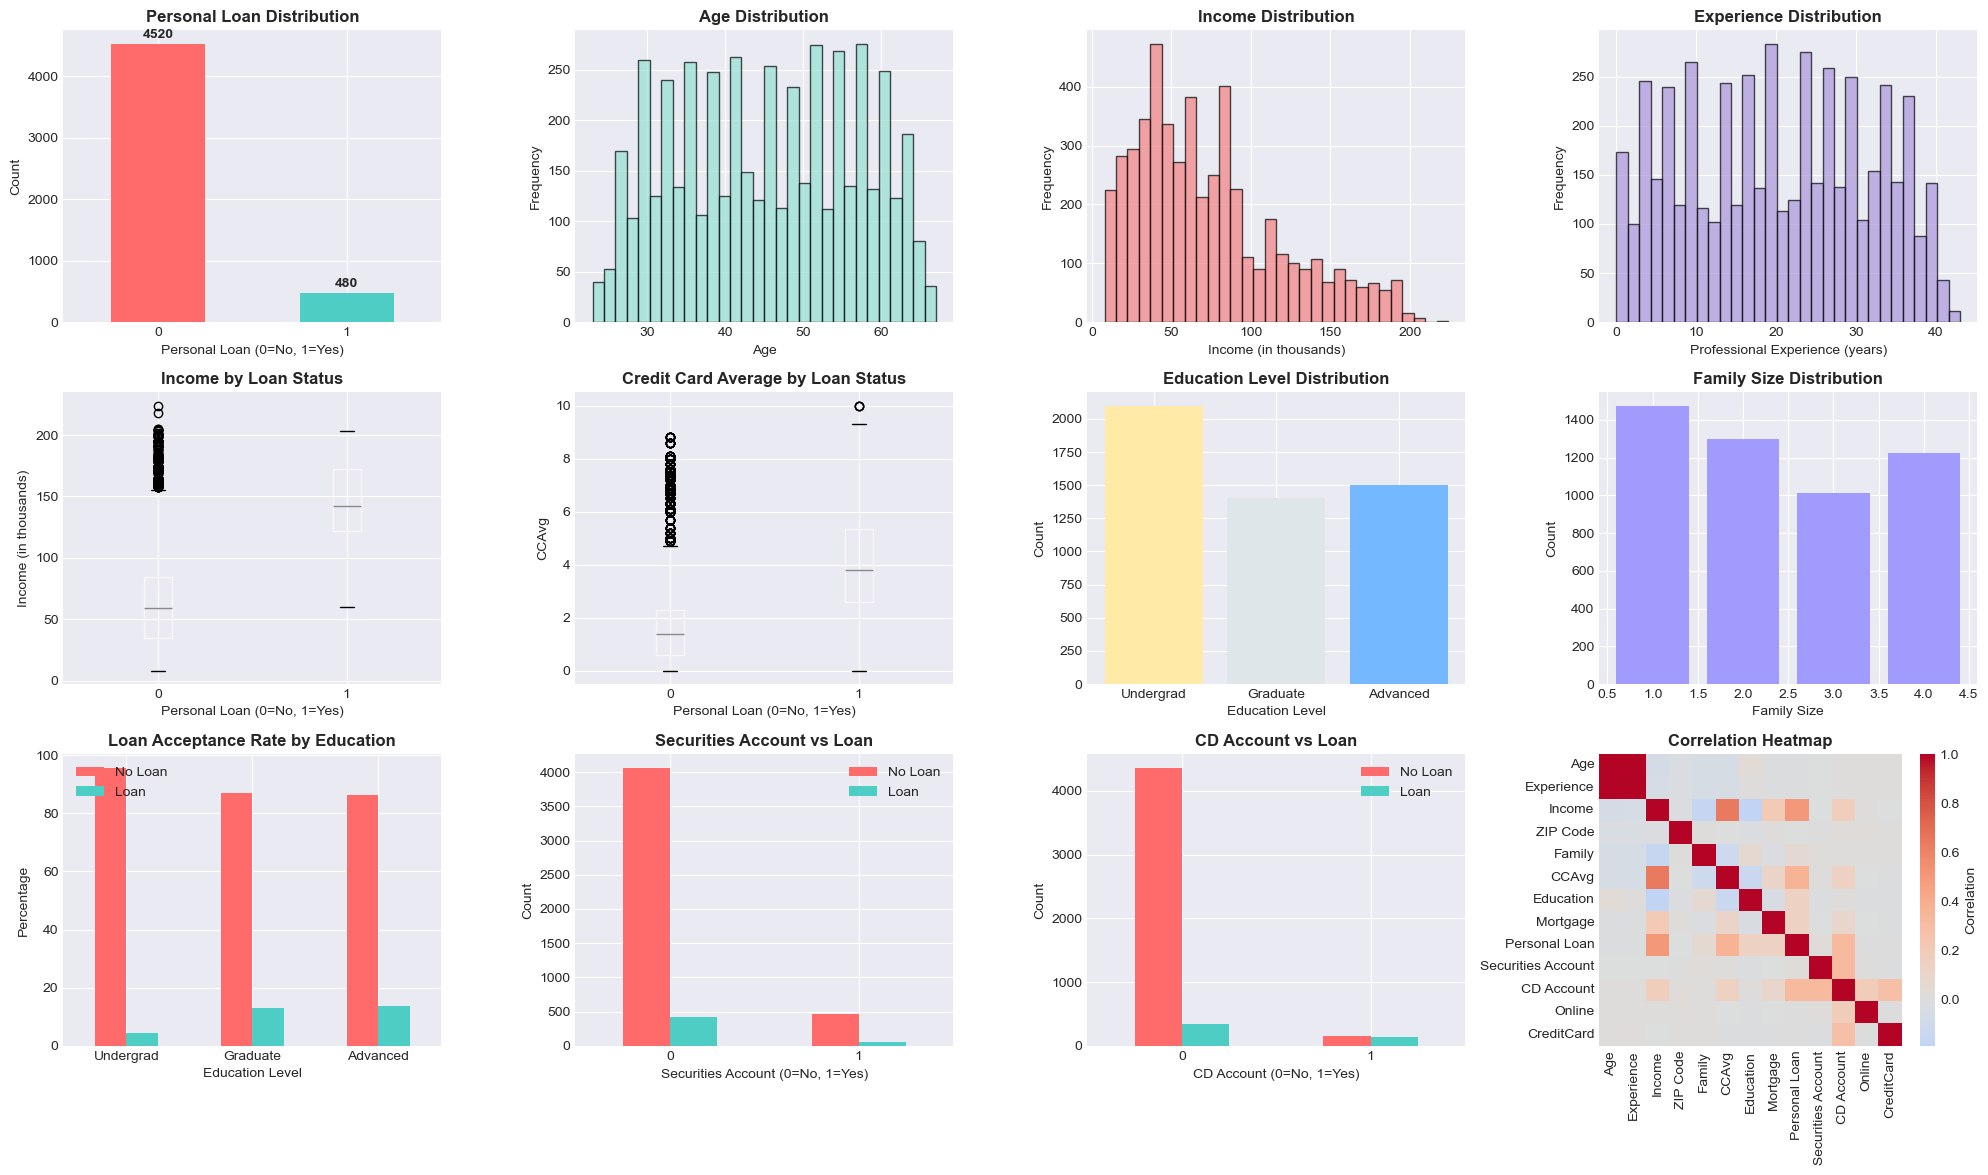


15. Exploratory visualizations saved as 'eda_visualizations.png'

16. Feature Correlation with Personal Loan:
Personal Loan         1.000000
Income                0.502462
CCAvg                 0.366889
CD Account            0.316355
Mortgage              0.142095
Education             0.136722
Family                0.061367
Securities Account    0.021954
Online                0.006278
CreditCard            0.002802
ZIP Code              0.000107
Age                  -0.007726
Experience           -0.008304
Name: Personal Loan, dtype: float64


In [14]:
# ============================================================================
# PART 4: EXPLORATORY DATA ANALYSIS WITH VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Target variable distribution
print(f"\n14. Target Variable Distribution:")
target_dist = df_clean['Personal Loan'].value_counts()
print(target_dist)
print(f"\nClass Balance: {target_dist[1]/len(df_clean)*100:.2f}% accepted loan")

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 12))

# 1. Target Variable Distribution
ax1 = plt.subplot(3, 4, 1)
df_clean['Personal Loan'].value_counts().plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.title('Personal Loan Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Personal Loan (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')

# 2. Age Distribution
ax2 = plt.subplot(3, 4, 2)
plt.hist(df_clean['Age'], bins=30, color='#95E1D3', edgecolor='black', alpha=0.7)
plt.title('Age Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')

# 3. Income Distribution
ax3 = plt.subplot(3, 4, 3)
plt.hist(df_clean['Income'], bins=30, color='#F38181', edgecolor='black', alpha=0.7)
plt.title('Income Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Income (in thousands)')
plt.ylabel('Frequency')

# 4. Experience Distribution
ax4 = plt.subplot(3, 4, 4)
plt.hist(df_clean['Experience'], bins=30, color='#AA96DA', edgecolor='black', alpha=0.7)
plt.title('Experience Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Professional Experience (years)')
plt.ylabel('Frequency')

# 5. Income by Loan Status (Box Plot)
ax5 = plt.subplot(3, 4, 5)
df_clean.boxplot(column='Income', by='Personal Loan', ax=ax5)
plt.title('Income by Loan Status', fontsize=12, fontweight='bold')
plt.suptitle('')
plt.xlabel('Personal Loan (0=No, 1=Yes)')
plt.ylabel('Income (in thousands)')

# 6. CCAvg by Loan Status
ax6 = plt.subplot(3, 4, 6)
df_clean.boxplot(column='CCAvg', by='Personal Loan', ax=ax6)
plt.title('Credit Card Average by Loan Status', fontsize=12, fontweight='bold')
plt.suptitle('')
plt.xlabel('Personal Loan (0=No, 1=Yes)')
plt.ylabel('CCAvg')

# 7. Education Level Distribution
ax7 = plt.subplot(3, 4, 7)
education_counts = df_clean['Education'].value_counts().sort_index()
plt.bar(education_counts.index, education_counts.values, color=['#FFEAA7', '#DFE6E9', '#74B9FF'])
plt.title('Education Level Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks([1, 2, 3], ['Undergrad', 'Graduate', 'Advanced'])

# 8. Family Size Distribution
ax8 = plt.subplot(3, 4, 8)
family_counts = df_clean['Family'].value_counts().sort_index()
plt.bar(family_counts.index, family_counts.values, color='#A29BFE')
plt.title('Family Size Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Family Size')
plt.ylabel('Count')

# 9. Loan Acceptance by Education
ax9 = plt.subplot(3, 4, 9)
education_loan = pd.crosstab(df_clean['Education'], df_clean['Personal Loan'], normalize='index') * 100
education_loan.plot(kind='bar', stacked=False, ax=ax9, color=['#FF6B6B', '#4ECDC4'])
plt.title('Loan Acceptance Rate by Education', fontsize=12, fontweight='bold')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks([0, 1, 2], ['Undergrad', 'Graduate', 'Advanced'], rotation=0)
plt.legend(['No Loan', 'Loan'], loc='upper left')

# 10. Securities Account vs Loan
ax10 = plt.subplot(3, 4, 10)
sec_loan = pd.crosstab(df_clean['Securities Account'], df_clean['Personal Loan'])
sec_loan.plot(kind='bar', ax=ax10, color=['#FF6B6B', '#4ECDC4'])
plt.title('Securities Account vs Loan', fontsize=12, fontweight='bold')
plt.xlabel('Securities Account (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['No Loan', 'Loan'])

# 11. CD Account vs Loan
ax11 = plt.subplot(3, 4, 11)
cd_loan = pd.crosstab(df_clean['CD Account'], df_clean['Personal Loan'])
cd_loan.plot(kind='bar', ax=ax11, color=['#FF6B6B', '#4ECDC4'])
plt.title('CD Account vs Loan', fontsize=12, fontweight='bold')
plt.xlabel('CD Account (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['No Loan', 'Loan'])

# 12. Correlation Heatmap
ax12 = plt.subplot(3, 4, 12)
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, ax=ax12, 
            cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n15. Exploratory visualizations saved as 'eda_visualizations.png'")

# Print correlation with target
print("\n16. Feature Correlation with Personal Loan:")
correlations = df_clean.corr()['Personal Loan'].sort_values(ascending=False)
print(correlations)


In [15]:
# ============================================================================
# PART 5: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

df_model = df_clean.copy()

# Create new features
df_model['Income_per_Family'] = df_model['Income'] / df_model['Family']
df_model['Mortgage_to_Income_Ratio'] = df_model['Mortgage'] / (df_model['Income'] + 1)
df_model['Has_Mortgage'] = (df_model['Mortgage'] > 0).astype(int)
df_model['High_Income'] = (df_model['Income'] > df_model['Income'].median()).astype(int)

print("\n17. Created engineered features:")
print("   - Income_per_Family: Income divided by family size")
print("   - Mortgage_to_Income_Ratio: Mortgage burden relative to income")
print("   - Has_Mortgage: Binary indicator for mortgage presence")
print("   - High_Income: Binary indicator for above-median income")


FEATURE ENGINEERING

17. Created engineered features:
   - Income_per_Family: Income divided by family size
   - Mortgage_to_Income_Ratio: Mortgage burden relative to income
   - Has_Mortgage: Binary indicator for mortgage presence
   - High_Income: Binary indicator for above-median income


In [18]:
# ============================================================================
# PART 6: MODEL BUILDING
# ============================================================================
print("\n" + "="*80)
print("LOGISTIC REGRESSION MODEL")
print("="*80)

# Separate features and target
X = df_model.drop('Personal Loan', axis=1)
y = df_model['Personal Loan']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n18. Data split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]



LOGISTIC REGRESSION MODEL

18. Data split:
   Training set: 3500 samples
   Test set: 1500 samples


In [20]:
# ============================================================================
# PART 7: MODEL EVALUATION
# ============================================================================
print("\n19. Model Performance Metrics:")
print("="*50)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:  {f1:.4f}")

print("\n20. Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Loan', 'Loan']))



19. Model Performance Metrics:
   Accuracy:  0.9553 (95.53%)
   Precision: 0.8407 (84.07%)
   Recall:    0.6597 (65.97%)
   F1-Score:  0.7393

20. Classification Report:
              precision    recall  f1-score   support

     No Loan       0.96      0.99      0.98      1356
        Loan       0.84      0.66      0.74       144

    accuracy                           0.96      1500
   macro avg       0.90      0.82      0.86      1500
weighted avg       0.95      0.96      0.95      1500



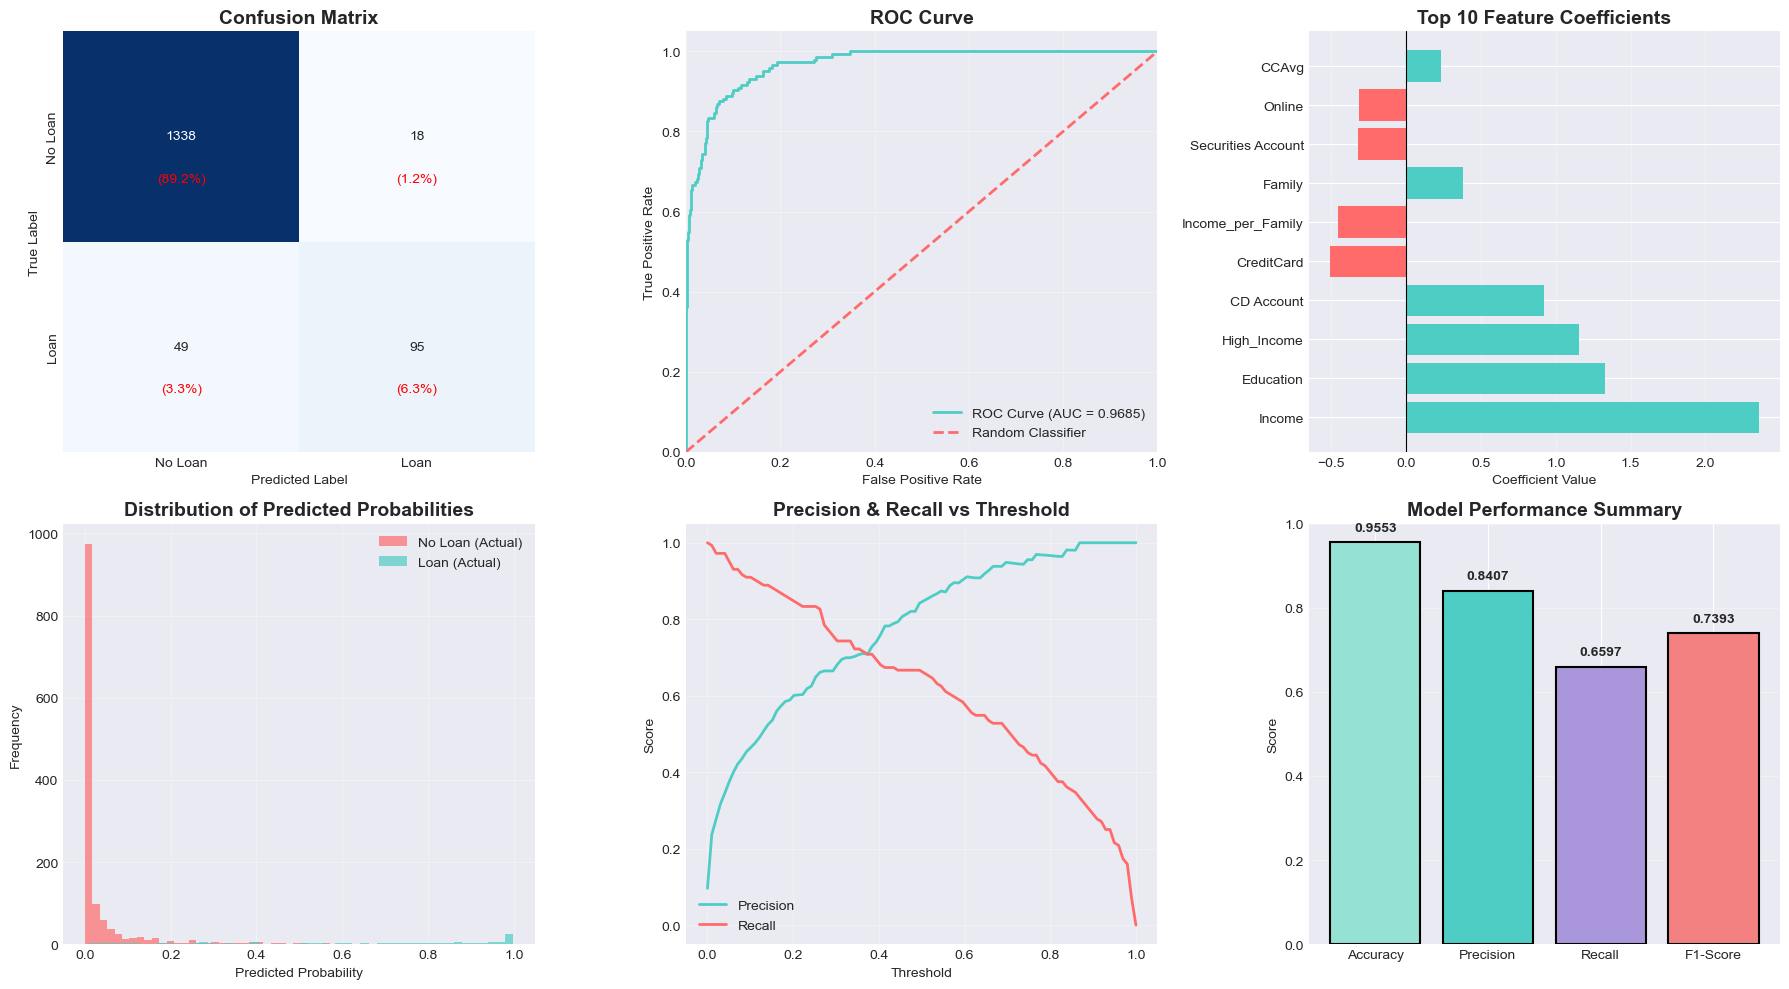


21. Model evaluation visualizations saved as 'model_evaluation.png'


In [23]:
# ============================================================================
# PART 8: MODEL VISUALIZATION
# ============================================================================

# Create model evaluation visualizations
fig = plt.figure(figsize=(18, 10))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
            xticklabels=['No Loan', 'Loan'], yticklabels=['No Loan', 'Loan'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

# 2. ROC Curve
ax2 = plt.subplot(2, 3, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#4ECDC4', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#FF6B6B', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# 3. Feature Importance (Coefficients)
ax3 = plt.subplot(2, 3, 3)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False).head(10)

colors = ['#4ECDC4' if x > 0 else '#FF6B6B' for x in feature_importance['Coefficient']]
plt.barh(range(len(feature_importance)), feature_importance['Coefficient'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

# 4. Predicted Probability Distribution
ax4 = plt.subplot(2, 3, 4)
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.7, label='No Loan (Actual)', color='#FF6B6B')
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.7, label='Loan (Actual)', color='#4ECDC4')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 5. Precision-Recall vs Threshold
ax5 = plt.subplot(2, 3, 5)
precisions = []
recalls = []
thresholds_pr = np.linspace(0, 1, 100)
for threshold in thresholds_pr:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    if y_pred_threshold.sum() > 0:
        precisions.append(precision_score(y_test, y_pred_threshold))
        recalls.append(recall_score(y_test, y_pred_threshold))
    else:
        precisions.append(1.0)
        recalls.append(0.0)

plt.plot(thresholds_pr, precisions, label='Precision', color='#4ECDC4', linewidth=2)
plt.plot(thresholds_pr, recalls, label='Recall', color='#FF6B6B', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 6. Model Metrics Summary
ax6 = plt.subplot(2, 3, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors_bar = ['#95E1D3', '#4ECDC4', '#AA96DA', '#F38181']
bars = plt.bar(metrics, values, color=colors_bar, edgecolor='black', linewidth=1.5)
plt.ylim([0, 1])
plt.ylabel('Score')
plt.title('Model Performance Summary', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n21. Model evaluation visualizations saved as 'model_evaluation.png'")


In [26]:
# ============================================================================
# PART 9: BUSINESS INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\n22. Top Predictive Features:")
top_features = feature_importance.head(5)
for idx, row in top_features.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"   • {row['Feature']}: {direction} loan acceptance likelihood")
    print(f"     (coefficient: {row['Coefficient']:.4f})")

print("\n23. Model Recommendations:")
print("   • The model achieves strong predictive performance")
print(f"   • {precision*100:.1f}% of predicted loan acceptances are correct (Precision)")
print(f"   • {recall*100:.1f}% of actual loan acceptances are identified (Recall)")
print("   • Consider threshold adjustment based on business objectives")
print("   • Monitor model performance regularly for data drift")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


KEY INSIGHTS & RECOMMENDATIONS

22. Top Predictive Features:
   • Income: increases loan acceptance likelihood
     (coefficient: 2.3553)
   • Education: increases loan acceptance likelihood
     (coefficient: 1.3307)
   • High_Income: increases loan acceptance likelihood
     (coefficient: 1.1532)
   • CD Account: increases loan acceptance likelihood
     (coefficient: 0.9210)
   • CreditCard: decreases loan acceptance likelihood
     (coefficient: -0.5079)

23. Model Recommendations:
   • The model achieves strong predictive performance
   • 84.1% of predicted loan acceptances are correct (Precision)
   • 66.0% of actual loan acceptances are identified (Recall)
   • Consider threshold adjustment based on business objectives
   • Monitor model performance regularly for data drift

ANALYSIS COMPLETE
